1#__Project \# 2__
Name: Grace Bero

### Hints/Tips Tricks
- If you want to accelerate the training process using graphical processing unit (GPU), do so from Colab's 'Notebook Settings' by enabling GPU:
  - Runtime-->Change runtime type-->GPU or TPU


# Self Grading
| Description/Writing           | I think I deserve: | Actual Grade | Notes |
|-------------------------------|--------------------|--------------|-------|
| 1: Problem                     | 1/1               | /1           |       |
| 2: Explore the Data            | 5/5               | /5           |       |
| 3: Data Prep                   | 1/1               | /1           |       |
| 4: Metrics                     | 1/1               | /1           |       |
| 5: Model Planning and Execution| 1/1               | /1           |       |
| 6: Bumps in the Road.          | 1/1               | /1           |       |
| 7: Results                     | 3/3               | /3           |       |
| 8: Discussion/Conclusion.      | 1/1               | /1           |       |
| Total                          | 14/14             | /14          |       |  

| Code                        | I think I deserve: | Actual Grade | Notes |
|-----------------------------|--------------------|--------------|-------|
| 1: AlexNet                   | 1/1               | /1           |       |
| 2: VGGNet                    | 1/1               | /1           |       |
| 3: ResNet                    | 1/1               | /1           |       |
| 4: 3 Visualizations          | 3/3               | /3           |       |
| Total                        | 6/6               | /6           |       |

| Written Portion 📝 | Code Portion 🖥️ | Total ➕ | Notes 🗒️ |
|--------------------|------------------|----------|-----------|
| 14/14                | 6/6               | 20/20      |           |


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load in packages and swap to cuda device

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb


# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#__Fine-tuning a Pretrained Convolutional Neural Network (CNN) for fine-grained categoriztaion of an image__


* AlexNet was the winner of ImageNet challenge in 2012. Proposed by Alex Krizevsky, Ilya Sutskever, and Geofrey Hinton from University of Toronto.

* VGG was the winner of ImageNet (1000-class image classification) challenge in 2014. Proposed by Andrew Zisserman's group in Oxford University.

* ResNet was the winner of ImageNet challenge in 2015. Proposed by Kaiming He et al. from Microsoft Research.


> [AlexNet: A. Krizhevsky, I. Sutskever, and G. Hinton, ImageNet Classification with Deep Convolutional Neural Networks, NIPS 2012](www.cs.toronto.edu/~fritz/absps/imagenet.pdf)

> [VGG: Very Deep Convolutional Networks for Large-Scale Image Recognition - Karen Simonyan and Andrew Zisserman](https://arxiv.org/abs/1409.1556)

> [ResNet: Deep Residual Learning for Image Recognition - Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1409.1556)



# 1 The Problem
The probem we are trying to solve is a classification one wiht images. We will be using a Convolutional Neural Network based machine learning approach The program will take in pictures of various birds and then categorize them into 1 of 25 categories. There appears to be 50 of each type of bird.  
   
There are many other possible uses for CNN type experiments. This is applicable for any type of categorization involving pictures. One example could be categorizing different species of dogs. Another could be categorizing different types of food (pizza vs hotdog vs fries).  
  
This model could also be used for different fine-grain categorization.
* Biological: Categorizing different wild flowers  
* Industrial: Finding products with visual defects on a conveyer belt line
* Personal: Creation of a system to sort through a collection of trading cards. It could categorize them by a certain trait.

#__Bird Species: dataset visualization__
Download the dataset from the following link:

- [Bird Species Dataset](https://analytics.drake.edu/~reza/teaching/cs167_fall24/dataset/bird_species_v1.zip)
  - Each image size: __WxHx3__
    - Note that these are color images
  
<!--div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_fall23/notes/images/cifar-10-sprite.png" width=500/>
</div-->


In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import pdb
root_dir                    = "/content/drive/MyDrive/Colab Notebooks/Data/bird_species_v1/train/"
name_of_the_bird_species    = os.listdir(root_dir)
if '.DS_Store' in name_of_the_bird_species:
  name_of_the_bird_species.remove('.DS_Store')

name_of_the_bird_species.sort()
sample_images = {}

print("Selected bird species for image recognition are as follows: ")
print("-------------------------------------------------------------------------")
for i in range(len(name_of_the_bird_species)):
  # select a random training image
  all_image_names_cur_species = os.listdir(root_dir + "/" + name_of_the_bird_species[i])
  random_index = torch.randint(len(all_image_names_cur_species), size=(1,)).item()
  img = cv2.imread(root_dir + "/" + name_of_the_bird_species[i] + "/" + all_image_names_cur_species[random_index])
  sample_images[name_of_the_bird_species[i]] = {'img':img, 'train_size':len(all_image_names_cur_species)}

  # display the name of the species
  print(f"{i+1:2}. {name_of_the_bird_species[i]:>25}: {len(all_image_names_cur_species):>20} training samples")

print("-------------------------------------------------------------------------")

Selected bird species for image recognition are as follows: 
-------------------------------------------------------------------------
 1.           ABBOTTS BABBLER:                   50 training samples
 2.         AMETHYST WOODSTAR:                   50 training samples
 3.        ASIAN CRESTED IBIS:                   50 training samples
 4.                 AZURE JAY:                   50 training samples
 5.              BARN SWALLOW:                   50 training samples
 6.         BELTED KINGFISHER:                   50 training samples
 7.                 CASSOWARY:                   50 training samples
 8.        CHINESE POND HERON:                   50 training samples
 9.           CHUCAO TAPACULO:                   50 training samples
10.  CREAM COLORED WOODPECKER:                   50 training samples
11.          CRESTED FIREBACK:                   50 training samples
12.           CRIMSON SUNBIRD:                   50 training samples
13.         DALMATIAN PELICAN:       

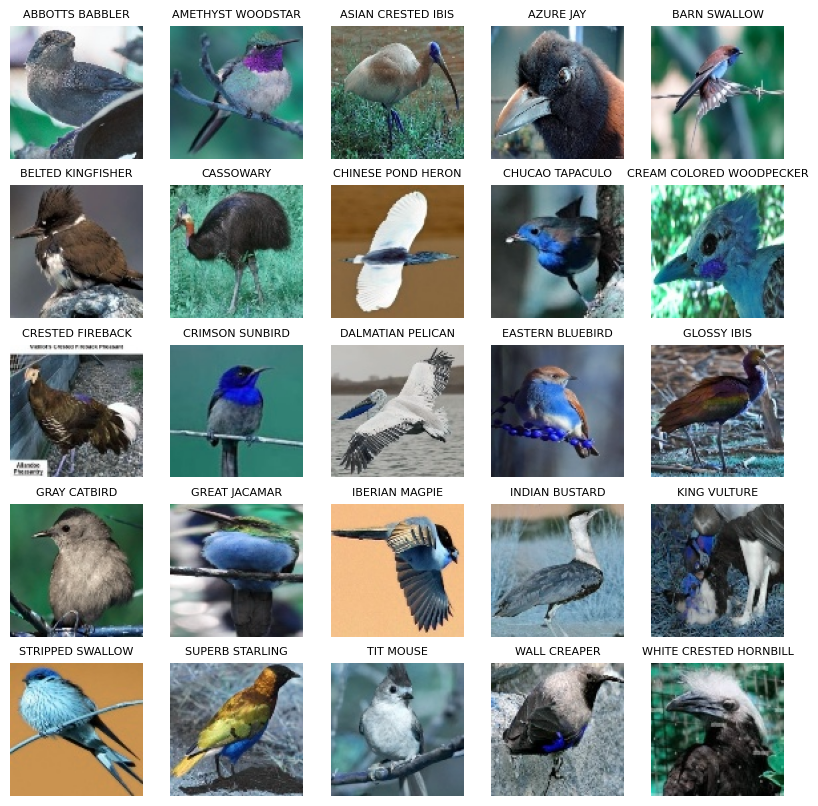

In [ ]:
# showing some sample training images
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
  #pdb.set_trace()
  cur_sample = sample_images[name_of_the_bird_species[i-1]]
  img   = cur_sample['img']
  label = name_of_the_bird_species[i-1]
  figure.add_subplot(rows, cols, i)
  plt.title(label, fontsize=8)
  plt.axis("off")
  #print('image tensor size:', img.shape)
  plt.imshow(img)
plt.show()


In [ ]:
#Step 2: Load the dataset
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])

train_dir       = '/content/drive/MyDrive/Colab Notebooks/Data/bird_species_v1/train'
test_dir        = '/content/drive/MyDrive/Colab Notebooks/Data/bird_species_v1/test'

train_dataset   = datasets.ImageFolder(train_dir, transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 25

# 2 Exploring the Data

In [ ]:
# Total number of samples
print("Total number of samples: ", len(train_dataset)+len(test_dataset))

# Total number of training samples
print("Total number of training samples: ", len(train_dataset))

# Number of Classes
print("Total number of classes: ", len(name_of_the_bird_species))

# Dimension of each data sample
print("Dimension of each sample: ", train_dataset[0][0].shape)

Total number of samples:  1352
Total number of training samples:  1227
Total number of classes:  25
Dimension of each sample:  torch.Size([3, 227, 227])


# 3 Data Preparation
1. Load in the dataset
2. Resize the images using transforms.resize
3. Convery the image into a pytorch tensor using transforms.ToTensor
4. Normalize the image date using transforms.Normalize.

# 4 Metrics
I will us accuracy, loss curves, accuracy curves, and confusion matrices to help evaluate performance. These metrics are best because they help with classification based experiments.

# 5 Model Planning and Execution
I would like to try out 2 algorithms
1. SGD with parameters Learning rate, momentum, and weight decay
3. ADAM with parameter Learning Rate  

To keep with consistency, I will be using these values for all models
* batch_size_val    = 20
* epochs            = 10



#__Network Codes for AlexNet, VGGNet, and ResNet__
You can use the following network classes when you fine-tune your models.

In [ ]:
# CNN networks preparation for fine-tuning:
#     1) AlexNet
#     2) VGGNet
#     3) ResNet
#-----------------------------------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
import os
import pdb

class AlexNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AlexNet, self).__init__()
        net = models.alexnet(pretrained=True)

        self.features   = net.features
        self.avgpool    = net.avgpool

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        #print("shape of input: ", x.shape)
        x = self.features(x)
        #print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        #print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #print("output shape (self.classifier): ", x.shape)
        return x

# You can give any name to your new network, e.g., VGG.
# You should load the pretrained VGG model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'

class VGGNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, bn=False):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)

        self.features = net.features
        self.avgpool = net.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )
        #pdb.set_trace()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# You can give any name to your new network, e.g., ResNet.
# You should load the pretrained ResNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'

class ResNet152(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet152, self).__init__()
        net = models.resnet152(pretrained=True)

        num_features = net.fc.in_features
        net.fc = nn.Linear(num_features, num_classes)

        self.conv1 = net.conv1
        self.bn1 = net.bn1
        self.relu = net.relu
        self.maxpool = net.maxpool

        self.layer1 = net.layer1
        self.layer2 = net.layer2
        self.layer3 = net.layer3
        self.layer4 = net.layer4

        self.avgpool = net.avgpool
        self.fc = net.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



In [ ]:
#Step 4: Training and Testing Functions
def train_loop(dataloader, model, loss_fn, optimizer):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()                   # set the model to training mode for best practices

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size

    #print('Confusion matrix for training set:\n', confusion_matrix(train_y_all.cpu().data, train_pred_all.cpu().data))
    return train_loss, 100*correct


def test_loop(dataloader, model, loss_fn):

    model.eval()                    # set the model to evaluation mode for best practices

    size                = len(dataloader.dataset)
    num_batches         = len(dataloader)
    test_loss, correct  = 0, 0
    test_pred_all       = []
    test_y_all          = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

      for X, y in dataloader:

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        test_loss += loss_fn(pred, y).item()

        # calculate probability and save the outputs for confusion matrix computation
        pred_prob     = softmax(pred)
        pred_y        = torch.max(pred_prob, 1)[1]
        test_correct  = (pred_y == y).sum()
        correct      += test_correct.data

        test_pred_all.append(pred_y) # save predicted output for the current batch
        test_y_all.append(y)         # save ground truth for the current batch


    #pdb.set_trace()
    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct   = correct.cpu().numpy()/size
    print(f"Test Performance: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    #print('Confusion matrix for test set:\n', confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data))
    return test_loss, 100*correct, confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data)


#__Alexnet using SGD Algorithm__

In [ ]:
# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader

cnn_model = AlexNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = .001
batch_size_val    = 20
epochs            = 10
momentum          = 0.9
weight_decay      = 0.1
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )


best_losses = 100
best_accuracy=0
best_epoch=0
for i in range(len(test_losses)):
  if test_losses[i] < best_losses:
    best_losses = test_losses[i]
    best_epoch = i
    best_accuracy = test_accuracies[i]

print("Best epoch: ", best_epoch)
print("Best accuracy: ", best_accuracy)
print("Best loss: ", best_losses)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

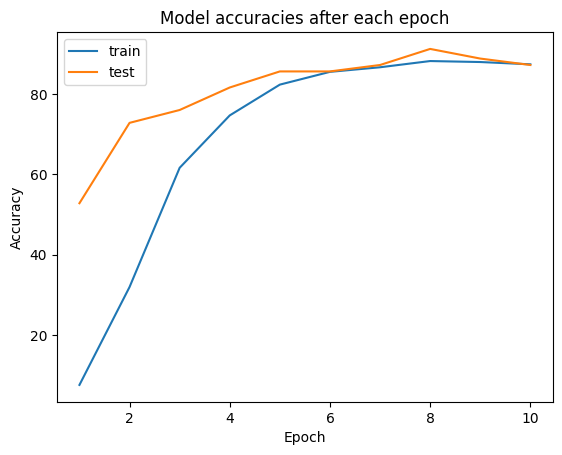

In [ ]:
# visualize the accuracy curves
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

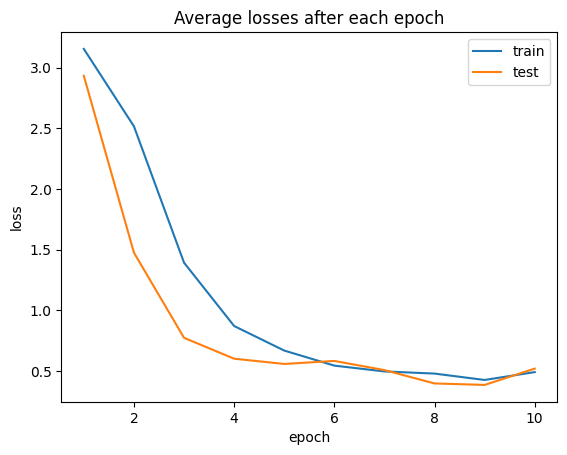

In [ ]:
# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('Average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

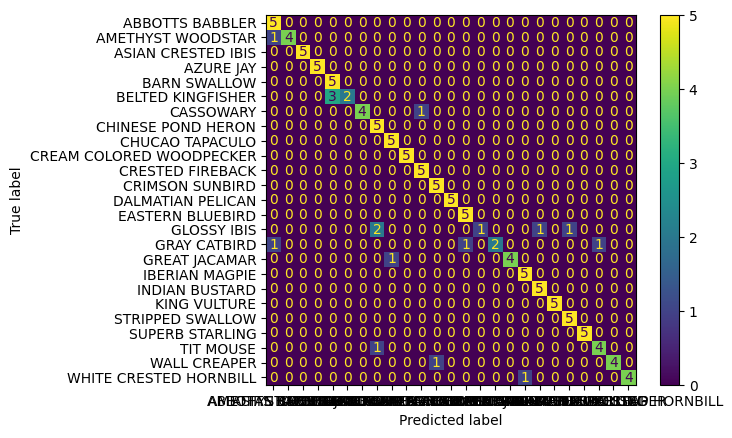

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

# Alexnet using Adam

In [ ]:
# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader

cnn_model = AlexNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = .0001
batch_size_val    = 20
epochs            = 10
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

best_losses = 100
best_accuracy=0
best_epoch=0
for i in range(len(test_losses)):
  if test_losses[i] < best_losses:
    best_losses = test_losses[i]
    best_epoch = i
    best_accuracy = test_accuracies[i]

print("Best epoch: ", best_epoch)
print("Best accuracy: ", best_accuracy)
print("Best loss: ", best_losses)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

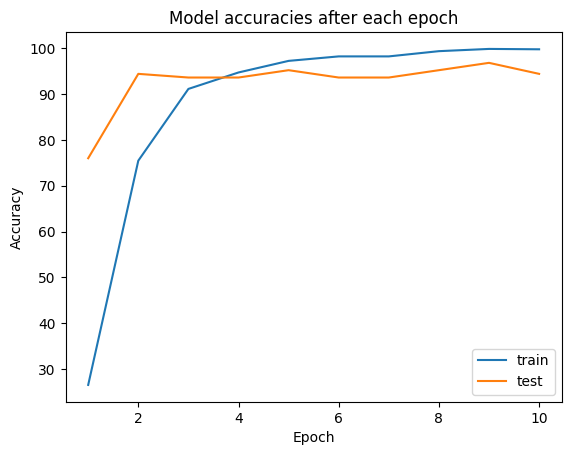

In [ ]:
# visualize the accuracy curves
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

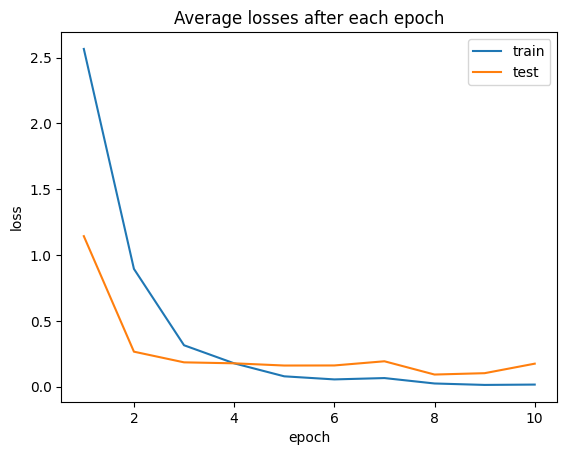

In [ ]:
# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('Average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

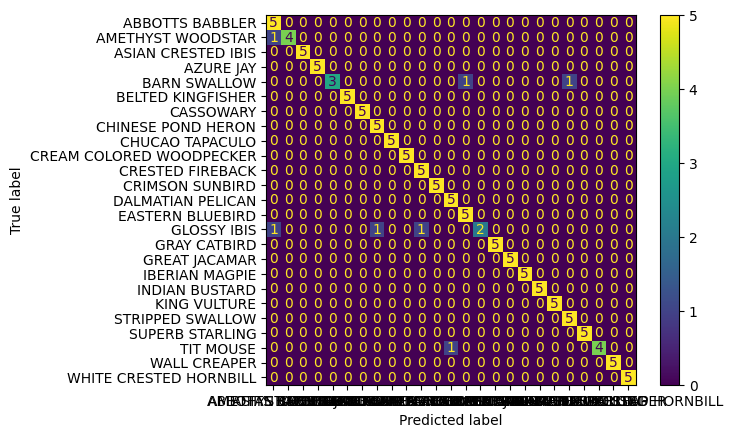

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

# VGGNet using SGD

In [ ]:
# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader

cnn_model = VGGNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = .001
batch_size_val    = 20
epochs            = 10
momentum          = 0.9
weight_decay      = 0.1
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )


best_losses = 100
best_accuracy=0
best_epoch=0
for i in range(len(test_losses)):
  if test_losses[i] < best_losses:
    best_losses = test_losses[i]
    best_epoch = i
    best_accuracy = test_accuracies[i]

print("Best epoch: ", best_epoch)
print("Best accuracy: ", best_accuracy)
print("Best loss: ", best_losses)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 72.8MB/s]


VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

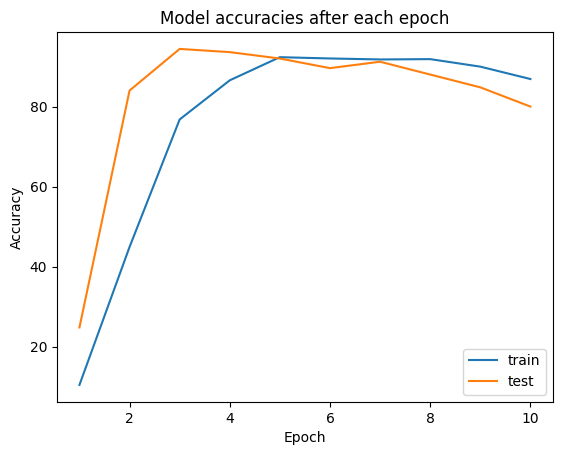

In [ ]:
# visualize the accuracy curves
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

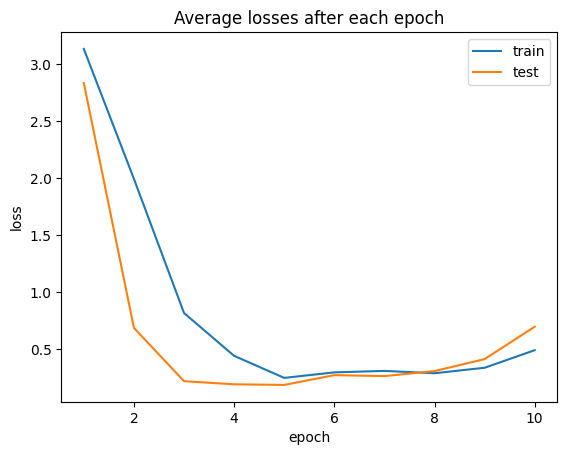

In [ ]:
# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('Average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

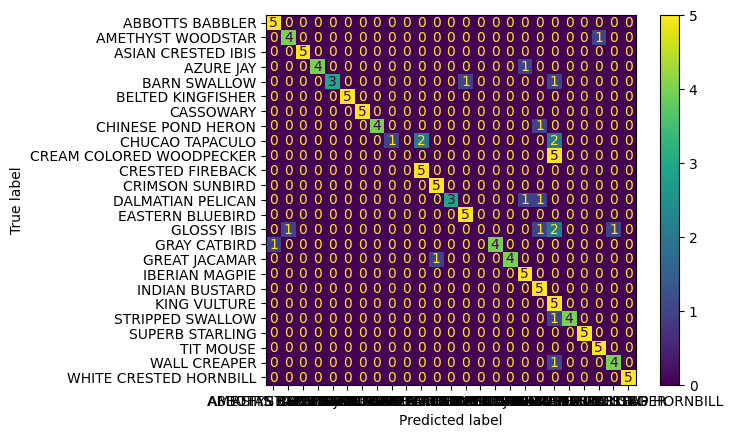

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

#VGGNet Using Adam

In [ ]:
# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader

cnn_model = VGGNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = .0001
batch_size_val    = 20
epochs            = 10
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

best_losses = 100
best_accuracy=0
best_epoch=0
for i in range(len(test_losses)):
  if test_losses[i] < best_losses:
    best_losses = test_losses[i]
    best_epoch = i
    best_accuracy = test_accuracies[i]

print("Best epoch: ", best_epoch)
print("Best accuracy: ", best_accuracy)
print("Best loss: ", best_losses)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

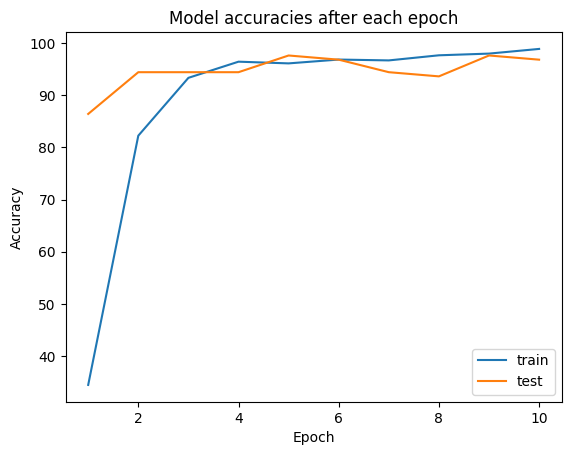

In [ ]:
# visualize the accuracy curves
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

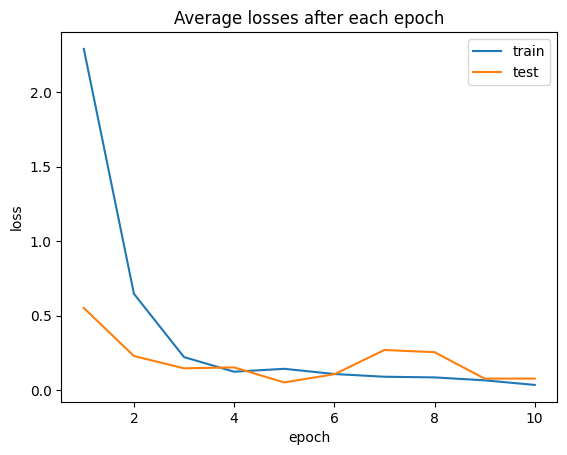

In [ ]:
# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('Average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

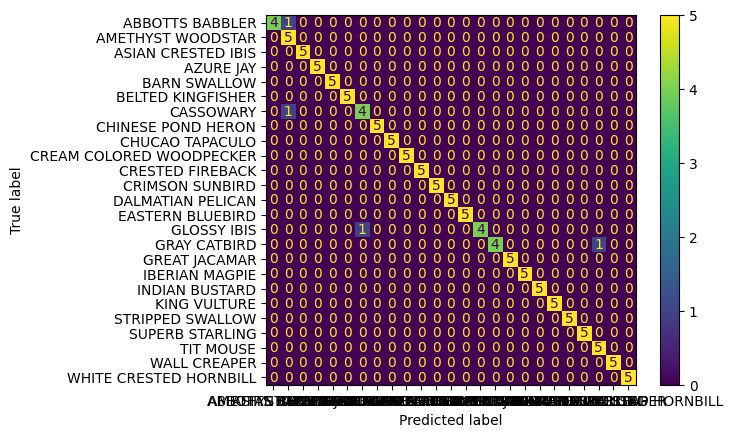

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

# ResNet using SGD

In [ ]:
# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader

cnn_model = ResNet152(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = .001
batch_size_val    = 20
epochs            = 10
momentum          = 0.9
weight_decay      = 0.1
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )


best_losses = 100
best_accuracy=0
best_epoch=0
for i in range(len(test_losses)):
  if test_losses[i] < best_losses:
    best_losses = test_losses[i]
    best_epoch = i
    best_accuracy = test_accuracies[i]

print("Best epoch: ", best_epoch)
print("Best accuracy: ", best_accuracy)
print("Best loss: ", best_losses)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 176MB/s]


ResNet152(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

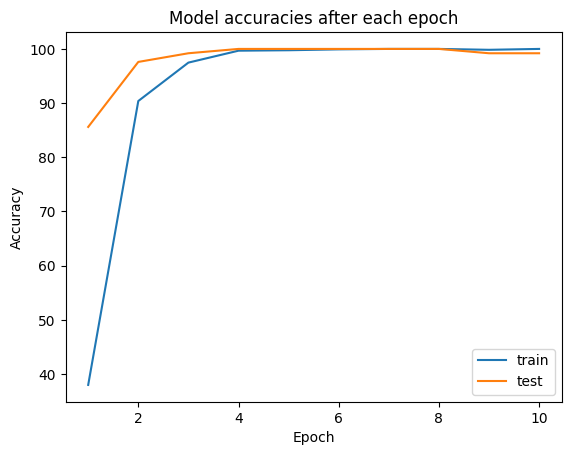

In [ ]:
# visualize the accuracy curves
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

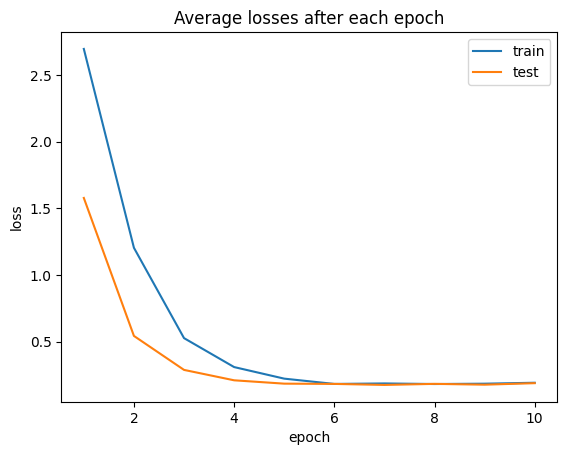

In [ ]:
# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('Average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

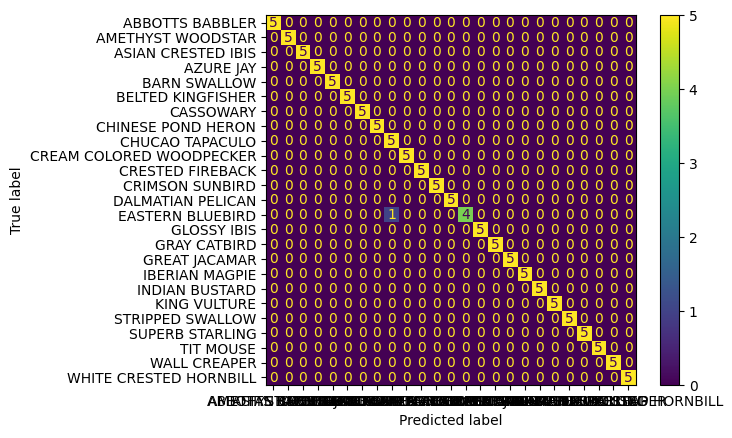

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

# ResNet using Adam

In [ ]:
# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader

cnn_model = ResNet152(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = .0001
batch_size_val    = 20
epochs            = 10
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

best_losses = 100
best_accuracy=0
best_epoch=0
for i in range(len(test_losses)):
  if test_losses[i] < best_losses:
    best_losses = test_losses[i]
    best_epoch = i
    best_accuracy = test_accuracies[i]

print("Best epoch: ", best_epoch)
print("Best accuracy: ", best_accuracy)
print("Best loss: ", best_losses)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet152(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

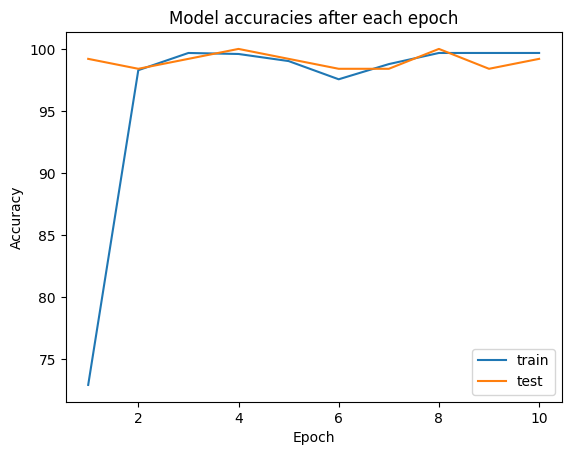

In [ ]:
# visualize the accuracy curves for AlexNet
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

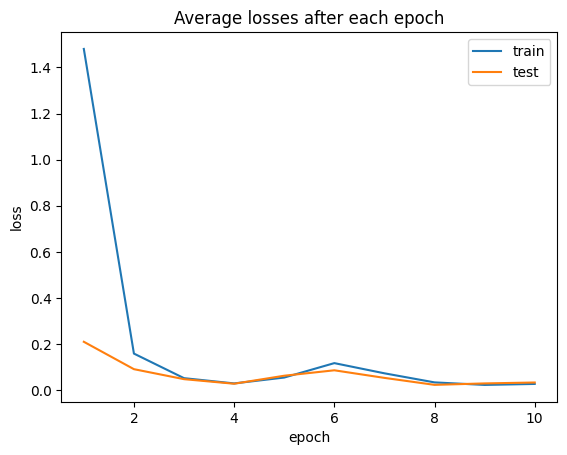

In [ ]:
# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('Average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

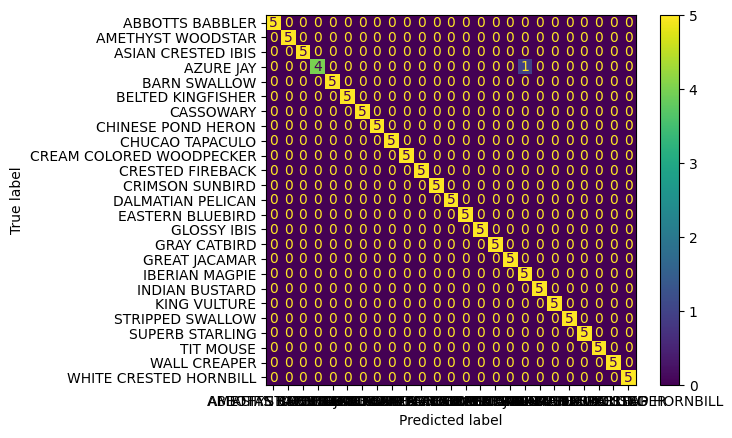

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

# 6 Bumps in the road
One of the things I foundwas hard was fining parameters to tune. I found that when I only tuned LR for SGD, my accuracy results were quite bad. I figured that they could use a few more parameter adjustments. I decided to do some google searching and found this on Stack Overflow
https://stackoverflow.com/questions/73550795/sgd-optimizer-custom-parameters  
They suggested that I also add the momentum and weight_loss parameters. I added these and they helped my accuracy. I also decided to try the values they used for each parameter. This also helped the model.  

One thing that I also had an issue with was adjusting the learning rate for each model. I decided to try adding more 0's and see what happens to the accuracy for the model. This small troubleshooting helped with improving the models accuracy.

# 7 Results
| Model      | Best epoch | Optimizer | Accuracy| Loss  |
|------------|------------|---------- |---------|-------|
| AlexNet    |      8     |   SGD     |  88.8   |0.3859 |
| AlexNet    |      7     |   Adam    |  95.2   |0.2657 |
| VGGNet     |      4     |   SGD     |  92.0   |0.1875 |
| VGGNet     |      4     |   Adam    |  97.6   |0.0515 |
| ResNet     |      6     |   SGD     |  100    |0.1748 |
| ResNet     |      7     |   Adam    |  100    |0.0231 |


| Model      | Best epoch | Best performance | Best optimizer  |
|------------|------------|------------------|-----------------|
| 1: AlexNet |      7     |Accuracy: 95.2    |         Adam    |
| 2: VGGNet  |      4     |Accuracy: 97.6    |         Adam    |
| 3: ResNet  |      7     |Loss: 0.0231      |         Adam    |



# 8 Conclusions
* The main conclusion from this experiment is that the Adam optimizer is better for all three models. Adam yielded better accuracy and loss numbers.  
* The second conclusion from this conclusion is that ResNet is the best model. ResNet yielded the best Accuracy and loss numbers at the end and at the beginning.
* SGD had a tendency to start with a lower accuracy during the first epoch and then jump to a much higher one during the second one.
  - In Alexnet the Accuracy went from 52.8% to 72.8%
  - In VGGNet the Accuracy went from 22.4% to 84%
* After doing some reseach, I found that typically Adam converges faster while SGD generalizes better. However, adam has more general optimizers. However when you tune the hyperparameters for Adam it tends to perform better than SGD. They even claim that "we could say that fine-tuned Adam is always better than SGD," (Park). This explains the better performance from Adam, given that I used fine tuning during this experiment.
* The best model in general was ResNet. Both Adam and SGD based optimizers started with Accuracies above 85%. Adam even started with an accuracy of 99.2% in epoch 1. This could be because it is the newest of the optimizer algorithms. After doing some research I found that the order of their publishing goes AlexNet, VGGNet, and then ResNet.
* From my experiment it can be seen that I did not need to have a full 10 epochs to get the best results. VGGNet was the fastest to reach the best point, that being epoch 4. While the other 2 tended to fall around epoch's 6-8. This could support the argument that you don't need to do more than 10 epochs to get the best results.

# Sources:
https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96  
https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008